In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# Load all FAH sheets
# =========================
xls = pd.ExcelFile("../Appendix B (shares).xls")

sheets = {
    "1994-98": "94-98 FAH",
    "2003-04": "03-04 FAH",
    "2005-06": "05-06 FAH",
    "2007-08": "07-08 FAH"
}

# Fruits and Dairy lists
fruits = [p.lower() for p in [
    "Apples as fruit", "Bananas", "Berries", "Grapes",
    "Melons", "Oranges, Total", "Other citrus fruit",
    "Stone fruit", "Tropical fruit"
]]

dairy = [p.lower() for p in [
    "Fluid Milk, Total", "Butter", "Cheese", "Yogurt", "Dairy, Other"
]]


In [3]:
def extract_data(sheet_name, group="Men"):
    df = pd.read_excel(xls, sheet_name=sheet_name, header=None)
    col_map = {"Boys": 1, "Girls": 4, "Men": 7, "Women": 10}
    if group not in col_map:
        raise ValueError("Group must be one of: Boys, Girls, Men, Women")

    sub = df.iloc[77:, [0, col_map[group]]]
    sub.columns = ["Product", "Mean"]

    # Normalize names
    sub["Product"] = sub["Product"].astype(str).str.strip().str.lower()
    sub = sub.dropna()

    sub = sub.drop_duplicates(subset=["Product"], keep="first")
    sub = sub.reset_index(drop=True)
    
    return sub

In [9]:
def build_dataset(group, product_list):
    records = {}
    normalized_list = [p.lower() for p in product_list]  # lowercase lookup list

    for period, sheet in sheets.items():
        extracted = extract_data(sheet, group=group)
        extracted = extracted[extracted["Product"].isin(product_list)]
        records[period] = extracted.set_index("Product")["Mean"]

    df_all = pd.DataFrame(records)

    # Keep only products that actually exist
    df_all = df_all.loc[df_all.index.intersection(product_list)]

    df_all = df_all[~df_all.index.duplicated(keep="first")]

    return df_all

men_fruits = build_dataset("Men", fruits)
women_fruits = build_dataset("Women", fruits)
men_dairy = build_dataset("Men", dairy)
women_dairy = build_dataset("Women", dairy)

In [10]:
def percent_change(df):
   
    return ((df["2007-08"] - df["1994-98"]) / df["1994-98"]) * 100

In [11]:
# Bar graph function
def plot_bars(df_fruits, df_dairy, title, filename):
    change_fruits = percent_change(df_fruits)
    change_dairy = percent_change(df_dairy)

    all_changes = pd.concat([change_fruits, change_dairy])
    categories = ["Fruit"] * len(change_fruits) + ["Dairy"] * len(change_dairy)
    all_changes = pd.DataFrame({
        "Product": all_changes.index,
        "Change": all_changes.values,
        "Category": categories
    })

    # Sort separately within fruits and dairy
    fruit_sorted = all_changes[all_changes["Category"] == "Fruit"].sort_values("Change")
    dairy_sorted = all_changes[all_changes["Category"] == "Dairy"].sort_values("Change")
    all_sorted = pd.concat([fruit_sorted, dairy_sorted])

    # Plot
    plt.figure(figsize=(12,6))
    plt.bar(all_sorted["Product"], all_sorted["Change"])
    plt.xticks(rotation=45, ha="right")
    plt.axhline(0, color="black", linewidth=0.8)
    plt.title(title)
    plt.ylabel("% Change (1994-98 → 2007-08)")
    plt.tight_layout()
    plt.savefig(filename, bbox_inches="tight")
    plt.show()

Men Fruits: ['apples as fruit', 'bananas', 'berries', 'grapes', 'melons', 'oranges, total', 'other citrus fruit', 'stone fruit', 'tropical fruit']
Men Dairy: ['fluid milk, total', 'butter', 'cheese', 'yogurt', 'dairy, other']


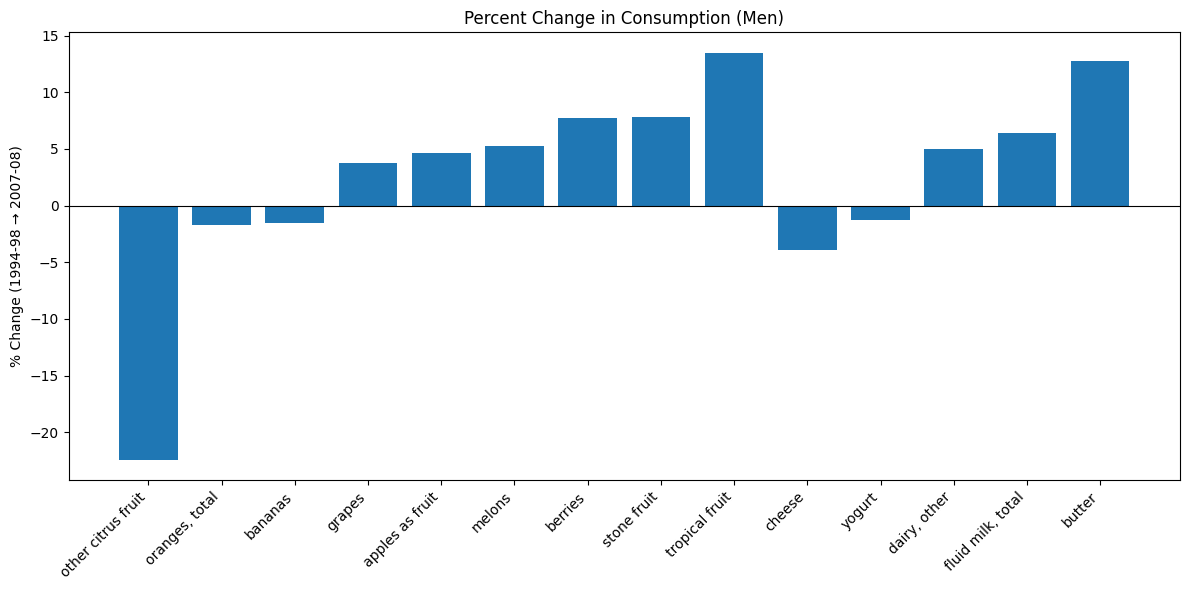

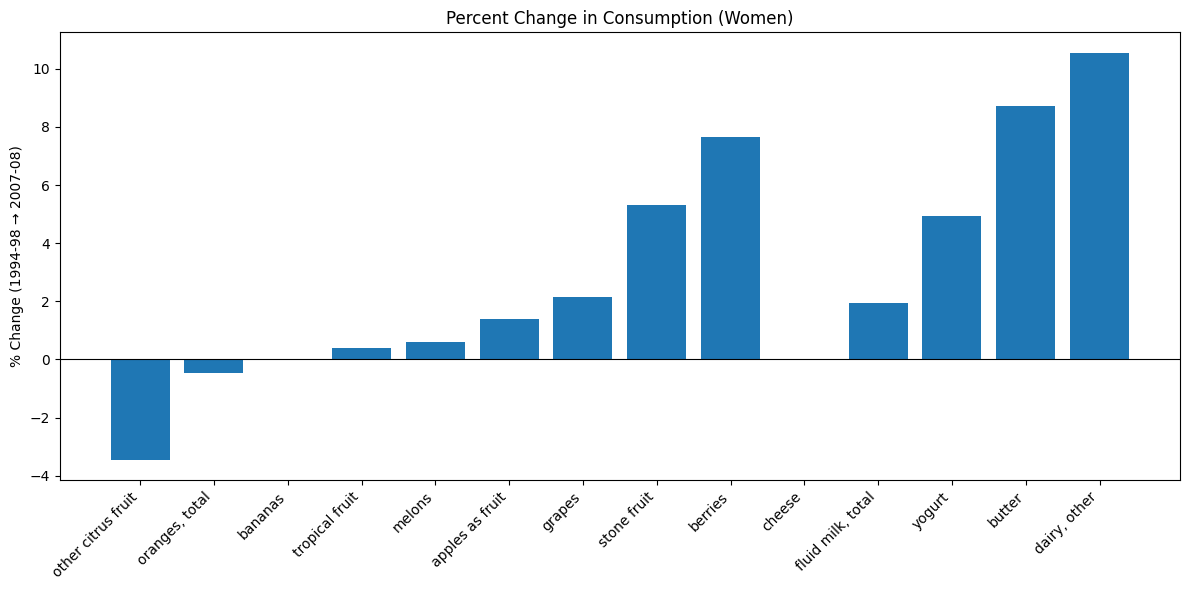

In [ ]:
# Debug check
print("Men Fruits:", men_fruits.index.tolist())
print("Men Dairy:", men_dairy.index.tolist())

# Plot Display
plot_bars(men_fruits, men_dairy, "Percent Change in Consumption (Men)", "men_change.png")
plot_bars(women_fruits, women_dairy, "Percent Change in Consumption (Women)", "women_change.png")